# Unit 1 - Cost of Teacher

Group members:

- Ole Magnus Laerum
- Piotr Franc

## Task description
Use the dataset BostonHousing2 (target value is target_column) with the following train1/train2/test partition. Use the dataset train1 to explore learning methods and techniques in a way that you want to reduce the amount of data used for training without compromising the performance of the model too much. Once the best methodology is selected, use it with train2 to show a plot of performance (RMSE) vs instances employed measured with the test partition. Grow this plot incrementally (i.e, add new instances to the already used instances) Select the instances of train2 without using the class label of the instances already not employed.

Train1 size: (202, 13)
Train2 size: (152, 13)
Test size: (152, 13)
Decision Tree RMSE: 6.546378066493998
Random Forest RMSE: 3.440341825313294
XGBoost RMSE: 3.113635954417989
SVR RMSE: 8.131664184381142


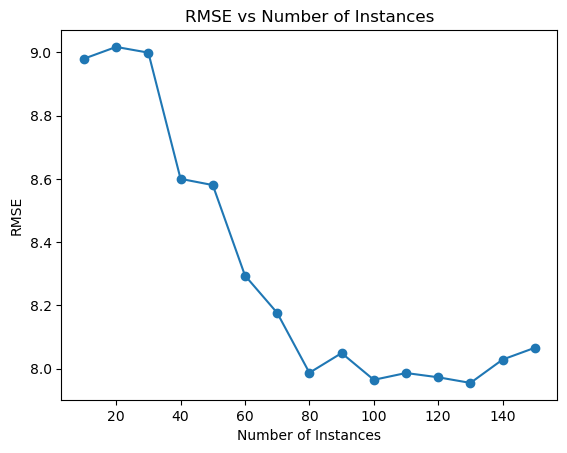

In [39]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml


### ---- Import the dataset -------------------------------------------------------------------------------------------------

boston = fetch_openml(data_id=531, as_frame=True, parser='pandas')
data = boston.frame

# Remove column index 4 to match R code
mddata = data.drop(columns=[data.columns[4]])

np.random.seed(280)

train1, temp = train_test_split(mddata, test_size=0.6, random_state=280)
train2, test = train_test_split(temp, test_size=0.5, random_state=280)

print("Train1 size:", train1.shape)
print("Train2 size:", train2.shape)
print("Test size:", test.shape)

### --- Preprocessing the dataset -- Fix the datatypes that are categories and not float64 -------------------------------------

# print(train1.dtypes) To find which is of the datatype category that needs to be fixed
# print(data.columns) To see the names of datatypes, to find the MEDV

train1["CHAS"] = train1["CHAS"].astype(int)
train1["RAD"] = train1["RAD"].astype(int)

train2["CHAS"] = train2["CHAS"].astype(int)
train2["RAD"] = train2["RAD"].astype(int)

test["CHAS"] = test["CHAS"].astype(int)
test["RAD"] = test["RAD"].astype(int)

target_column = "MEDV"

## ---- Solution 2 - Decision Tree ----------------------------------------------------------------------------------------------------
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(max_depth=1000, random_state=13)
model.fit(train1.drop(columns=[target_column]), train1[target_column])

preds = model.predict(test.drop(columns=[target_column]))
rmse = np.sqrt(mean_squared_error(test[target_column], preds))
print("Decision Tree RMSE:", rmse) 

## ---- Solution 3 - Random Forest ----------------------------------------------------------------------------------------------------
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(train1.drop(columns=[target_column]), train1[target_column])

preds = model.predict(test.drop(columns=[target_column]))
rmse = np.sqrt(mean_squared_error(test[target_column], preds))
print("Random Forest RMSE:", rmse)

### ---- Solution 4 - Gradient Boosting ----------------------------------------------------------------------------------------------------
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
model.fit(train1.drop(columns=[target_column]), train1[target_column])

preds = model.predict(test.drop(columns=[target_column]))
rmse = np.sqrt(mean_squared_error(test[target_column], preds))
print("XGBoost RMSE:", rmse)

### ---- Solution 5 - Support Vector Regression (SVR) ----------------------------------------------------------------------------------------------------
from sklearn.svm import SVR

model = SVR(kernel='rbf')
model.fit(train1.drop(columns=[target_column]), train1[target_column])

preds = model.predict(test.drop(columns=[target_column]))
rmse = np.sqrt(mean_squared_error(test[target_column], preds))
print("SVR RMSE:", rmse)





### ---- Plotting ----------------------------------------------------------------------------------------------------

import matplotlib.pyplot as plt

rmse_values = []
num_instances = []

for size in range(10, len(train2), 10):  # Incrementally add data
    partial_train2 = train2.iloc[:size]
    model.fit(partial_train2.drop(columns=[target_column]), partial_train2[target_column])
    
    preds = model.predict(test.drop(columns=[target_column]))
    rmse = np.sqrt(mean_squared_error(test[target_column], preds))
    
    rmse_values.append(rmse)
    num_instances.append(size)

# Plot RMSE vs Number of Instances
plt.plot(num_instances, rmse_values, marker='o', linestyle='-')
plt.xlabel("Number of Instances")
plt.ylabel("RMSE")
plt.title("RMSE vs Number of Instances")
plt.show()


In [40]:
def evaluate_model_incrementally(model, train2, test, target_column):
    rmse_values = []
    num_instances = []

    for size in range(10, len(train2), 10):  # Incrementally add data
        partial_train2 = train2.iloc[:size]
        model.fit(partial_train2.drop(columns=[target_column]), partial_train2[target_column])
        
        preds = model.predict(test.drop(columns=[target_column]))
        rmse = np.sqrt(mean_squared_error(test[target_column], preds))
        
        rmse_values.append(rmse)
        num_instances.append(size)

    # Plot RMSE vs Number of Instances
    plt.plot(num_instances, rmse_values, marker='o', linestyle='-')
    plt.xlabel("Number of Instances")
    plt.ylabel("RMSE")
    plt.title("RMSE vs Number of Instances")
    plt.show()

    return rmse_values, num_instances

In [41]:
### ---- Solution 1 - Linear Regression - Baseline ------------------------------------------------------------------------

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(train1.drop(columns=[target_column]), train1[target_column])

preds = model.predict(test.drop(columns=[target_column]))
rmse = np.sqrt(mean_squared_error(test[target_column], preds))
print("Linear Regression RMSE:", rmse)


Linear Regression RMSE: 5.314499152788179
